In [1]:
# requires bqplot-image-gl

In [1]:
import numpy as np
from ase.io import read
from bqplot_image_gl import ImageGL
from bqplot_image_gl.interacts import MouseInteraction 
from bqplot.interacts import PanZoom
from traitlets import link
import ipywidgets as widgets

from abtem.base_classes import Event, watched_method
from abtem.visualize.widgets import quick_sliders
from abtem.visualize import show_atoms
from abtem.structures import orthogonalize_cell
from abtem.visualize.bqplot import create_image_figure, update_bqplot_image, create_reset_button
from abtem import *
import matplotlib.pyplot as plt

# Interactive CBED

In [2]:
class PointScan:

    def __init__(self, position):
        self._position = position
        self.changed = Event()
    
    @property
    def position(self):
        return self._position
    
    @position.setter
    @watched_method('changed')
    def position(self, position):
        self._position = position

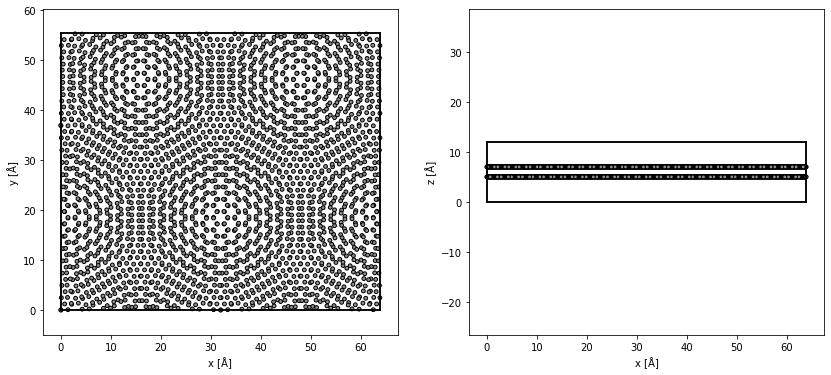

In [3]:
import os
import sys
import numpy as np
from ase import Atoms
from ase.parallel import parprint
from abtem.structures import standardize_cell

def angle_between(v1, v2):    
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    return np.math.atan2(np.cross(v1, v2), np.dot(v1, v2))


def graphene_bilayer(n, a=2.46, d=3):
    m = n - 1
    gcd = np.gcd(n, m)
    n = int(n / gcd)
    m = int(m / gcd)
    
    positions = np.array([[0, 0], [0, a / np.sqrt(3)]])
    cell = np.array([[a, 0], [0.5 * a, 1.5 * a / np.sqrt(3)]])
    
    for i in range(2 * n - 3):
        if (i == 0) or (i % 2 == 1):
            positions = np.append(positions, (positions[i*2] + cell[1]).reshape(1, -1), axis=0)
            positions = np.append(positions, (positions[i*2 + 1] + cell[1]).reshape(1, -1), axis=0)
        if (i == 0) or (i % 2 == 0):
            positions = np.append(positions, (positions[i*2] + cell[0] - cell[1]).reshape(1, -1), axis=0)
            positions = np.append(positions, (positions[i*2 + 1] + cell[0] - cell[1]).reshape(1, -1), axis=0)

    for i in range(2 * (n - 1) * (2*n - 1)):
        positions = np.append(positions, (positions[i] + cell[0]).reshape(1, -1), axis=0)
    
    last = 2 * (n - 1) * (2 * n - 1)
    side = 2 * (2 * n - 1)
    for i in range(n - 1):
        for j in range(last, last + side - 4):
            positions = np.append(positions, (positions[j] + cell[0]).reshape(1, -1), axis=0)
        last = last + side
        side = side - 4
    
    v1 = m * cell[0] + n * cell[1]
    v2 = n * cell[0] + m * cell[1]
    theta = angle_between(v2, v1)
    
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    v2 = np.dot(R, v2)
    v3 = np.dot(R, -m * cell[0] + (n + m) * cell[1])
    
    super_cell = np.array([np.append(v2, 0), np.append(v3, 0), [0, 0, 2 * d]])

    rotated_positions = positions + np.array([-0.5*a, 0.5*a / np.sqrt(3)])
    rotated_positions = np.dot(R,rotated_positions.T).T
    
    positions = np.hstack((positions, np.ones(len(positions)).reshape(-1, 1)))
    rotated_positions = np.hstack((rotated_positions, d * np.ones(len(rotated_positions)).reshape(-1, 1)))
    
    atoms = Atoms('C' * len(positions), positions=positions, cell=super_cell, pbc=True)
    rotated_atoms = Atoms('C' * len(rotated_positions), positions=rotated_positions, cell=super_cell, pbc=True)
    
    atoms += rotated_atoms
    atoms.wrap()
    standardize_cell(atoms)
    return atoms


atoms = graphene_bilayer(8, d=3)
atoms = orthogonalize_cell(atoms)

atoms *= (2,1,1)

atoms.center(axis=2,vacuum=5)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))
show_atoms(atoms,plane='xy',ax=ax1)
show_atoms(atoms,plane='xz',ax=ax2);

In [4]:
S = SMatrix(expansion_cutoff=10,
            interpolation=1, 
            energy=60e3,
            gpts=512,
            semiangle_cutoff=10, 
            device='gpu')

potential = Potential(atoms, precalculate=False, device='gpu', projection='infinite', parametrization='kirkland')

S = S.multislice(potential, pbar=True)
S = S.downsample(max_angle=90)

In [5]:
figure1, image1 = create_image_figure()
figure2, image2 = create_image_figure()

figure1.axes[0].label = 'x [Å]'
figure1.axes[1].label = 'y [Å]'
figure2.axes[0].label = 'alpha_x [mrad]'
figure2.axes[1].label = 'alpha_y [mrad]'

point_scan = PointScan((0,0))

block_toggle = widgets.ToggleButton(
    value=False,
    description='Block direct beam',
)

def callback(*args, **kwargs):
    wave = S.collapse(point_scan.position)
    measurement = wave.intensity()
    update_bqplot_image(image1, measurement)
    block = S.ctf.semiangle_cutoff
    if block_toggle.value:
        block = S.ctf.semiangle_cutoff
    else:
        block = False
    
    measurement = wave.diffraction_pattern('limit', block_zeroth_order=block)    
    update_bqplot_image(image2, measurement)


mouse_interaction = MouseInteraction(x_scale=figure1.axes[0].scale, 
                                     y_scale=figure1.axes[1].scale, 
                                     cursor='crosshair')

def change_position(_, msg, __):
    point_scan.position = (msg['domain']['x'], msg['domain']['y'])

mouse_interaction.on_msg(change_position)

pan_zoom = PanZoom(scales={'x': [figure1.axes[0].scale], 'y': [figure1.axes[1].scale]})

reset_button = create_reset_button(figure1)

interacts = {'Move probe':mouse_interaction, 'Pan/Zoom': pan_zoom}

interact_toggle = widgets.ToggleButtons(options=interacts)

link((interact_toggle, 'value'), (figure1, 'interaction'))

toolbar = widgets.HBox([interact_toggle, reset_button])


block_toggle.observe(callback, 'value')
point_scan.changed.register(callback)
S.changed.register(callback)

ctf_sliders = quick_sliders(S.ctf, 
                        semiangle_cutoff=(2, 14, .5),
                        focal_spread=(0,500,1),
                        defocus=(-10000,10000,10),
                        Cs=(-1e8,1e8,1e3),
                        astigmatism=(-1000,1000,10),
                        astigmatism_angle=(0,2*np.pi,.1)
                        )


widgets.VBox([widgets.HBox([figure1,figure2])] + [toolbar] + ctf_sliders + [block_toggle])